In [17]:
%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
from matplotlib import rc;rc('text', usetex=True);rc('font', weight='bold');matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']
import os
rc('text.latex',preamble=r'\usepackage{/Users/sraghunathan/.configs/apjfonts}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'

In [19]:
import argparse, sys, numpy as np, scipy as sc, warnings, os
sys.path.append('/Users/sraghunathan/Research/SPTPol/analysis/git/DRAFT/modules/')
import flatsky, misc
import ilc, foregrounds as fg

#import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
#warnings.filterwarnings('ignore', category=DeprecationWarning)
#warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

In [20]:
#some constants
h=6.62607004e-34 #Planck constant in m2 kg / s
k_B=1.38064852e-23 #Boltzmann constant in m2 kg s-2 / K-1
Tcmb = 2.73 #Kelvin

In [21]:
#params
paramfile = 'params.ini'

# read and store param dict
param_dict = misc.fn_get_param_dict(paramfile)
el = np.arange(param_dict['lmax'])
include_gal = param_dict['include_gal'] ##1
if not include_gal:
    param_dict['which_gal_mask'] = 3
which_gal_mask = param_dict['which_gal_mask']
s4like_mask = param_dict['s4like_mask']
try:
    remove_atm = param_dict['remove_atm']
except:
    remove_atm = 0    

In [22]:
#S4 specs
specs_dic = {
#freq: [beam_arcmins, white_noise_T, elknee_T, alphaknee_T, whitenoise_P, elknee_P, alphaknee_P] 
#20: [10.0, None, None, None, None, None, None],
#27: [7.4, 21.8, 471., 3.5, 30.8, 700, 1.4],
#39: [5.1, 12.4, 428., 3.5, 17.6, 700, 1.4], 
93: [2.2, 2.0, 2154., 3.5, 2.9, 700, 1.4],
145: [1.4, 2.0, 4364., 3.5, 2.8, 700, 1.4],
225: [1.0, 6.9, 7334., 3.5, 9.8, 700, 1.4],
278: [0.9, 16.7, 7308., 3.5, 23.6, 700, 1.4],
#225: [1.0, 100., 7334., 3.5, 9.8, 700, 1.4],
#278: [0.9, 100., 7308., 3.5, 23.6, 700, 1.4],

}

if remove_atm:
    specs_dic = {
    #freq: [beam_arcmins, white_noise_T, elknee_T, alphaknee_T, whitenoise_P, elknee_P, alphaknee_P] 
    #20: [10.0, None, None, None, None, None, None],
    #27: [7.4, 21.8, 471., 0., 30.8, 700, 0.],
    #39: [5.1, 12.4, 428., 0., 17.6, 700, 0.], 

    93: [2.2, 2.0, 2154., 0., 2.9, 700, 0.],
    145: [1.4, 2.0, 4364., 0., 2.8, 700, 0.],
    225: [1.0, 6.9, 7334., 0., 9.8, 700, 0.],
    278: [0.9, 16.7, 7308., 0., 23.6, 700, 0.],
#    225: [1.0, 100., 7334., 0., 9.8, 700, 0.],
#    278: [0.9, 100., 7308., 0., 23.6, 700, 0.],        
    }


freqarr = sorted( specs_dic.keys() )
nc = len( freqarr )

corr_noise = 1
if corr_noise:
    corr_noise_bands = {20: [20], 27:[39], 39:[27], 93:[145], 145:[93], 225: [278], 278: [225]}
else:
    corr_noise_bands = {20: [20], 27:[39], 39:[27], 93:[93], 145:[145], 225: [225], 278: [278]}
rho = 0.9

freqcalib_fac = None
final_comp = 'cmb'
TParr = ['T', 'P']
which_spec_arr = ['TT', 'EE', 'TE']
#which_spec_arr = ['TT', 'EE']
#which_spec_arr = ['TE']
##include_gal = 1

In [23]:
#beam and noise arr
beamarr = []
noisearr_T, elkneearr_T, alphakneearr_T = [], [], []
noisearr_P, elkneearr_P, alphakneearr_P = [], [], []
for freq in freqarr:
    beam_arcmins, white_noise_T, elknee_T, alphaknee_T, whitenoise_P, elknee_P, alphaknee_P = specs_dic[freq]
    beamarr.append(beam_arcmins)
    noisearr_T.append(white_noise_T)
    noisearr_P.append(whitenoise_P)
    elkneearr_T.append(elknee_T)
    elkneearr_P.append(elknee_P)
    alphakneearr_T.append(alphaknee_T)
    alphakneearr_P.append(alphaknee_P)    

print(elkneearr_T)

[2154.0, 4364.0, 7334.0, 7308.0]


In [24]:
#collect beam and noise into a dic; elknee and alpha into a dic
beam_noise_dic = {}
elknee_dic = {}
for TP in TParr:
    beam_noise_dic[TP] = {}
    elknee_dic[TP] = {} 
    if TP == 'T':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_T, elkneearr_T, alphakneearr_T
    elif TP == 'P':
        freqarr, beamarr, noisearr, elkneearr, alphakneearr = freqarr, beamarr, noisearr_P, elkneearr_P, alphakneearr_P

    for (freq, beam, noise, elknee, alphaknee) in zip(freqarr, beamarr, noisearr, elkneearr, alphakneearr):
        beam_noise_dic[TP][freq] = [beam, noise]
        elknee_dic[TP][freq] = [elknee, alphaknee]

In [25]:
#get beam deconvolved noise nls
nl_dic = {}
for TP in TParr:
    nl_dic[TP]={}
    for freq1 in freqarr:
        beamval1, noiseval1 = beam_noise_dic[TP][freq1]
        elknee1, alphaknee1 = elknee_dic[TP][freq1]
        for freq2 in freqarr:        
            beamval2, noiseval2 = beam_noise_dic[TP][freq2]
            elknee2, alphaknee2 = elknee_dic[TP][freq2]
            
            if freq1 == freq2:
                nl = misc.get_nl(noiseval1, el, beamval1, elknee = elknee1, alphaknee = alphaknee1)
            else:
                if freq2 in corr_noise_bands[freq1]:
                    nl = misc.get_nl(noiseval1, el, beamval1, elknee = elknee1, alphaknee = alphaknee1, \
                                     beamval2 = beamval2, noiseval2 = noiseval2, elknee2 = elknee2, alphaknee2 = alphaknee2, rho = rho)
                else:
                    nl = np.zeros( len(el) )
            nl[el<=param_dict['lmin']] = 0.
            ##nl[nl == 0.] = np.min(nl[nl!=0.])/1e3
            nl_dic[TP][(freq1, freq2)] = nl
print(nl_dic['T'].keys())

dict_keys([(93, 93), (93, 145), (93, 225), (93, 278), (145, 93), (145, 145), (145, 225), (145, 278), (225, 93), (225, 145), (225, 225), (225, 278), (278, 93), (278, 145), (278, 225), (278, 278)])


In [26]:
#get beams
bl_dic = misc.get_beam_dic(freqarr, beam_noise_dic['T'], param_dict['lmax'])
print(bl_dic.keys())
if (0):
    for freq in freqarr:
        plot(bl_dic[freq], label = freq)
    legend(loc = 1)

dict_keys([93, 145, 225, 278])


In [27]:
#get the CMB, noise, and foreground covriance
try:
    ignore_fg = param_dict['ignore_fg']
except:
    ignore_fg = []

ignore_fg.append(final_comp.lower()) #the required component need not go into the covariance matrix.
print(ignore_fg)

#freqarr = [145]
#param_dict['which_gal_mask'] = 0
cl_dic = {}
for which_spec in which_spec_arr:
    if which_spec == 'TT':
        el, cl_dic[which_spec] = ilc.get_analytic_covariance(param_dict, freqarr, \
                nl_dic = nl_dic['T'], ignore_fg = ignore_fg, include_gal = include_gal, bl_dic = bl_dic)
    else:
        el, cl_dic[which_spec] = ilc.get_analytic_covariance\
                    (param_dict, freqarr, nl_dic = nl_dic['P'], ignore_fg = ignore_fg, which_spec = which_spec, \
                    pol_frac_per_cent_dust = param_dict['pol_frac_per_cent_dust'], \
                    pol_frac_per_cent_radio = param_dict['pol_frac_per_cent_radio'], \
                    pol_frac_per_cent_tsz = param_dict['pol_frac_per_cent_tsz'], \
                    pol_frac_per_cent_ksz = param_dict['pol_frac_per_cent_ksz'], \
                    include_gal = include_gal, bl_dic = bl_dic)
print(cl_dic.keys(), cl_dic.keys())

['cmb']
dict_keys(['TT', 'EE', 'TE']) dict_keys(['TT', 'EE', 'TE'])


In [28]:
#colordic = {27:'indigo', 39:'royalblue', 93: 'lightgreen', 145: 'darkgreen', 225: 'goldenrod', 278: 'darkred'}
colordic = {}
dummy_freqarr = [20, 27, 39, 93, 145, 225, 278]
colorarr = [cm.jet(int(d)) for d in np.linspace(0, 255, len(dummy_freqarr) )]
for fcntr, f in enumerate( dummy_freqarr ):
    colordic[f] = colorarr[fcntr]
colordic[27] = 'navy'
colordic[39] = 'royalblue'
colordic[93] = 'lightseagreen'
colordic[145] = 'darkgreen'

In [29]:
#get the residual power now
cl_residual_arr, weights_arr = ilc.residual_power(param_dict, freqarr, el, cl_dic, final_comp = final_comp, freqcalib_fac = freqcalib_fac, return_weights = 1)

In [30]:
cl_residual, weights_dic = {}, {}
for which_spec in which_spec_arr:
    if which_spec == 'TT':
       cl_res = cl_residual_arr[0]
       weights = weights_arr[:nc, 0]
    elif which_spec == 'EE':
       cl_res = cl_residual_arr[1]
       weights = weights_arr[nc:, 1]
    elif which_spec == 'TE':
       cl_res = cl_residual_arr[2]
       weights = np.asarray( [weights_arr[nc:, 0], weights_arr[:nc, 1]] )
    cl_residual[which_spec], weights_dic[which_spec] = cl_res, weights

In [31]:
#plot and results file name
freqarr_str = '-'.join( np.asarray( freqarr ).astype(str) )
which_spec_arr_str = '-'.join( np.asarray( which_spec_arr ).astype(str) )
#opfname = 'results/galactic_sims/S4_ilc_20204020_galaxy%s_%s.npy' %(include_gal, freqarr_str)
#opfname = 'results/galactic_sims/S4_ilc_zonca_sims_20204028_galaxy%s_%s_%s.npy' %(include_gal, freqarr_str, which_spec_arr_str)
parent_folder = 'results/20200601'
opfname = '%s/S4_ilc_galaxy%s_%s_%s.npy' %(parent_folder, include_gal, freqarr_str, which_spec_arr_str)

if not corr_noise:
    opfname = opfname.replace('.npy', '_nocorrnoise.npy')
    
if s4like_mask:
    opfname = opfname.replace(parent_folder, '%s/s4like_mask/' %(parent_folder))
    
if include_gal:
    opfname = opfname.replace('.npy', '_galmask%s.npy' %(which_gal_mask))

if remove_atm:
    opfname = opfname.replace('.npy', '_noatmnoise.npy')

if include_gal:    
    cl_gal_folder = param_dict['cl_gal_folder']
    if cl_gal_folder.find('CUmilta')>-1:
        opfname = opfname.replace('.npy', '_CU.npy')
    else:
        opfname = opfname.replace('.npy', '_AZ.npy')

try:
    param_dict['cl_gal_dic_sync_fname_forced']
    opfname = opfname.replace('.npy', '_forcingsynctoCU.npy')
except:
    pass

#plname = opfname.replace('.npy', '.png').replace('S4_ilc', 'plot_S4_ilc')
if not s4like_mask:
    plname = opfname.replace('.npy', '.png').replace(parent_folder, '%s/plots/' %(parent_folder))
else:
    plname = opfname.replace('.npy', '.png').replace('%s/s4like_mask/' %(parent_folder), '%s/s4like_mask/plots/' %(parent_folder))
plfolder = '/'.join(plname.split('/')[:-1])
os.system('mkdir -p %s' %(plfolder))
print(opfname)
print(plname)

results/20200601/s4like_mask//S4_ilc_galaxy1_93-145-225-278_TT-EE-TE_galmask3_AZ.npy
results/20200601/s4like_mask/plots//S4_ilc_galaxy1_93-145-225-278_TT-EE-TE_galmask3_AZ.png


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


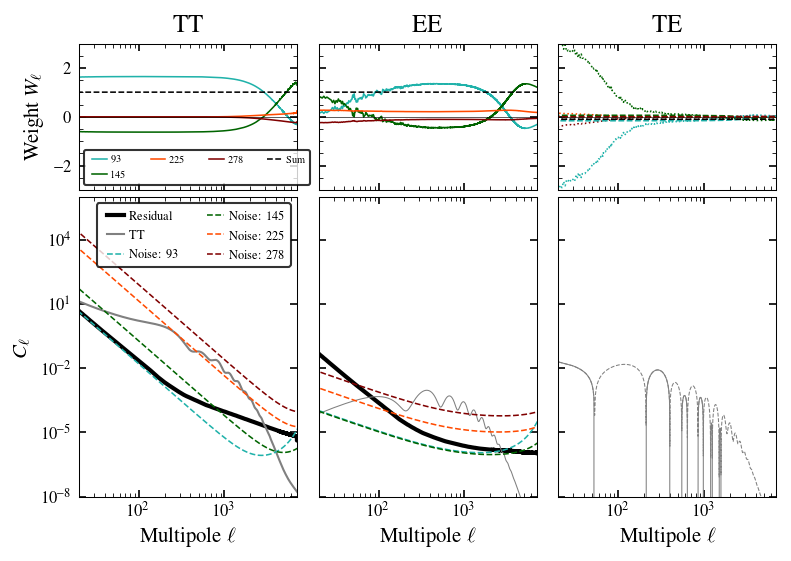

In [32]:
freq0, lmax = param_dict['freq0'], param_dict['lmax']
if include_gal:
    foregrounds_to_plot = ['kSZ', 'tSZ', 'DG-Po', 'DG-Cl', 'RG', 'dust', 'sync']
    pol_foregrounds_to_plot = ['dust', 'sync']
else:
    foregrounds_to_plot = ['kSZ', 'tSZ', 'DG-Po', 'DG-Cl', 'RG']
    pol_foregrounds_to_plot = []

#CAMB output for plotting
#camb_file = param_dict['Dlfile_len']
camb_file = '%s/%s' %(param_dict['data_folder'], param_dict['Dlfile_len'])
el_camb = np.loadtxt(camb_file, usecols = [0])
dl_camb = np.loadtxt(camb_file, usecols = [1,2,3,4])

cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

clf(); 
fsval = 8
lwval = 0.75
plot_weights = 1
xmin, xmax = 20, 7000
if plot_weights:
    tr, tc = 6, len(which_spec_arr)
    subplots_adjust(wspace=0.1, hspace = 0.1)
    #first plot weights
    rspan, cspan = 2, 1
    curr_row = 0
    for cntr, which_spec in enumerate( which_spec_arr ):
        ax = subplot2grid((tr,tc), (curr_row, cntr), rowspan = rspan, colspan = cspan, xscale = 'log')#, yscale = 'log')
        if which_spec == 'TE':
            for teiter in range(2):
                if teiter == 0:
                    lsval = ':'
                else:
                    lsval = '--'
                for frqcntr, freq in enumerate( freqarr ):
                    plot(weights_dic[which_spec][teiter][frqcntr], color = colordic[freq], label = r'%s' %(freq), lw = lwval, ls = lsval)
                plot(np.sum(weights_dic[which_spec][teiter], axis = 0), 'k--', label = r'Sum', lw = lwval, ls = lsval)        
        else:
            for frqcntr, freq in enumerate( freqarr ):
                plot(weights_dic[which_spec][frqcntr], color = colordic[freq], label = r'%s' %(freq), lw = lwval)
            plot(np.sum(weights_dic[which_spec], axis = 0), 'k--', label = r'Sum', lw = lwval)
        axhline(lw=0.3);
        #xlabel(r'Multipole $\ell$');
        setp(ax.get_xticklabels(which = 'both'), visible=False)
        if cntr == 0:
            ylabel(r'Weight $W_{\ell}$')
            legend(loc = 3, fontsize = 5, ncol = 4, handlelength = 2., handletextpad = 0.1)
        else:
            setp(ax.get_yticklabels(which = 'both'), visible=False)
        ylim(-3., 3.);
        xlim(xmin, xmax);
        for label in ax.get_xticklabels(): label.set_fontsize(fsval)
        for label in ax.get_yticklabels(): label.set_fontsize(fsval)        

        title(r'%s' %(which_spec))#, fontsize = 10)

    curr_row = rspan
    rspan = tr - rspan
for cntr, which_spec in enumerate( which_spec_arr ):
    if plot_weights:
        #ax = subplot(1,2,cntr+1, xscale = 'log', yscale = 'log')
        ax = subplot2grid((tr,tc), (curr_row, cntr), rowspan = rspan, colspan = cspan, xscale = 'log', yscale = 'log')
    else:
        ax = subplot(1,2,cntr+1, xscale = 'log', yscale = 'log')
    plot(el, cl_residual[which_spec], 'black', lw = 2., label = r'Residual')
    if which_spec == 'TT':
        plot(el_camb, cl_TT, 'gray', lw = 1., label = r'TT')
        '''
        cl_fg = np.zeros(len(el))
        for curr_fg in foregrounds_to_plot:
            if curr_fg == 'dust':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'dust', 145, 145, 'TT', bl_dic = bl_dic, el = el)
            elif curr_fg == 'sync':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'sync', 145, 145, 'TT', bl_dic = bl_dic, el = el)
            else:
                el_, cl_curr_fg = fg.get_foreground_power_spt(curr_fg, freq1 = freq0, lmax = lmax)
            #plot(el, cl_curr_fg, lw = 0.5, ls = '--', label = r'150: %s' %(curr_fg), alpha = 0.4)
            cl_fg += cl_curr_fg
        plot(el, cl_fg, lw = 5., ls = '--', label = r'150: All foregrounds', alpha = 1.)
        '''
    elif which_spec == 'EE':
        plot(el_camb, cl_EE, 'gray', lw = 0.5)#, label = r'EE')
        '''
        for curr_fg in pol_foregrounds_to_plot:
            if curr_fg == 'dust':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'dust', 145, 145, 'EE', bl_dic = bl_dic, el = el)
            elif curr_fg == 'sync':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'sync', 145, 145, 'EE', bl_dic = bl_dic, el = el)
            plot(el, cl_curr_fg, lw = 0.5, ls = '--', label = r'150: %s' %(curr_fg), alpha = 0.4)
        '''
    elif which_spec == 'TE':
        plot(el_camb, cl_TE, 'gray', ls = '-', lw = 0.5)#, label = r'TE')        
        plot(el_camb, abs( cl_TE ), 'gray', ls = '--', lw = 0.5) 
        '''
        for curr_fg in pol_foregrounds_to_plot:
            if curr_fg == 'dust':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'dust', 145, 145, 'EE', bl_dic = bl_dic, el = el)
            elif curr_fg == 'sync':
                el, cl_curr_fg = fg.get_cl_galactic(param_dict, 'sync', 145, 145, 'EE', bl_dic = bl_dic, el = el)
            plot(el, cl_curr_fg, lw = 0.5, ls = '--', label = r'150: %s' %(curr_fg), alpha = 0.4)
        '''
    #for freq in freqarr:
    #    plot(el, cl_dic[which_spec][(freq,freq)], color = colordic[freq], lw = 0.5, ls = '-', label = r'%s' %(freq), alpha = 1.)        
    for freq in freqarr:
        if which_spec == 'TT':
            nl = nl_dic['T'][(freq, freq)]
        elif which_spec == 'EE':
            nl = nl_dic['P'][(freq, freq)]
        elif which_spec == 'TE':
            nl = nl_dic['T'][(freq, freq)] * 0.
        plot(el, nl, color = colordic[freq], lw = lwval, ls = '--', label = r'Noise: %s' %(freq))#, alpha = 0.5)
    #legend(loc=3, fancybox=1, ncol = 4, fontsize = 6);
    
    xlim(xmin, xmax);
    ylim(1e-8,1e6);
    xlabel(r'Multipole $\ell$')
    if cntr == 0: 
        ylabel(r'$C_{\ell}$')
        legend(loc = 1, fontsize = 6, ncol = 2, handlelength = 2., handletextpad = 0.1)
    else:
        setp(ax.get_yticklabels(which = 'both'), visible=False)
    for label in ax.get_xticklabels(): label.set_fontsize(fsval)
    for label in ax.get_yticklabels(): label.set_fontsize(fsval)
        
#tit = 'Galaxy = %s; Mask = %s; Bands = %s' %(include_gal, param_dict['which_gal_mask'], str(freqarr))
if remove_atm:
    tit = 'Galaxy = %s; Mask = %s; Bands = %s; no 1/f' %(include_gal, param_dict['which_gal_mask'], str(freqarr))
else:
    if include_gal:
        tit = 'Galaxy = %s; Mask = %s; Bands = %s' %(include_gal, param_dict['which_gal_mask'], str(freqarr))    
    else:
        tit = 'Galaxy = %s; Mask = N/A; Bands = %s' %(include_gal, str(freqarr))    
if not corr_noise:
    tit = '%s; No corr. noise' %(tit)
#suptitle(r'%s' %tit, x = 0.53, y = 1.)
######savefig(plname)
show()


0.77325439453125
results/20200601/s4like_mask//S4_ilc_galaxy0_93-145-225-278_TT-EE.npy


In [ ]:
cl_gal_dic_dust_fname = param_dict['cl_gal_dic_dust_fname']
try:
    cl_gal_folder = param_dict['cl_gal_folder']
    cl_gal_dic_dust_fname = '%s/%s' %(cl_gal_folder, cl_gal_dic_dust_fname)
except:
    pass
    
galdustsims_cl = np.load(cl_gal_dic_dust_fname, allow_pickle=1, encoding = 'latin1').item()
fsky_val = galdustsims_cl['fsky_arr'][param_dict['which_gal_mask']]
print(fsky_val)
opdic = {}
opdic['el'] = el
opdic['cl_residual'] = cl_residual
opdic['freqcalib_fac'] = freqcalib_fac
opdic['param_dict'] = param_dict
opdic['fsky_val'] = fsky_val
opdic['which_gal_mask'] = which_gal_mask
opdic['weights'] = weights_dic
#opdic['nl_dic'] = nl_dic
opdic['beam_noise_dic'] = beam_noise_dic
opdic['elknee_dic'] = elknee_dic
######np.save(opfname, opdic)
print(opfname)